In [1]:
# You may want to install "gprof2dot"
import io
from collections import Counter

import numpy as np
import scipy.io
import sklearn.model_selection
import sklearn.tree
from numpy import genfromtxt
from scipy import stats
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

import pydot
import pandas as pd

np.random.seed(42)

eps = 1e-5  # a small number

# 4.1

In [2]:
class DecisionTree:
    def __init__(self, max_depth=3, feature_labels=None):
        self.max_depth = max_depth
        self.features = feature_labels
        self.left, self.right = None, None  # for non-leaf nodes
        self.split_idx, self.thresh = None, None  # for non-leaf nodes
        self.data, self.pred = None, None  # for leaf nodes

    @staticmethod
    def information_gain(X, y, thresh):
       # compute entropy of the parent node
        parent_entropy = stats.entropy(np.bincount(y))

        # split the data based on the threshold
        left_idxs = X < thresh
        left_y = y[left_idxs]
        right_y = y[~left_idxs]

        # compute the entropy of the child nodes
        left_entropy = stats.entropy(np.bincount(left_y))
        right_entropy = stats.entropy(np.bincount(right_y))

        # compute the information gain of the split
        left_weight = left_y.size / y.size
        right_weight = right_y.size / y.size
        info_gain = parent_entropy - left_weight * left_entropy - right_weight * right_entropy

        return info_gain


    @staticmethod
    def gini_impurity(X, y, thresh):
        # split the data based on the threshold
        left_idxs = X < thresh
        left_y = y[left_idxs]
        right_y = y[~left_idxs]

        # compute the Gini impurity of the child nodes
        left_gini = 1 - np.sum((left_y == c).sum()**2 for c in np.unique(left_y)) / left_y.size
        right_gini = 1 - np.sum((right_y == c).sum()**2 for c in np.unique(right_y)) / right_y.size

        # compute the weighted average of the child nodes' Gini impurity
        left_weight = left_y.size / y.size
        right_weight = right_y.size / y.size
        gini_impurity = left_weight * left_gini + right_weight * right_gini

        return gini_impurity

    def split(self, X, y, idx, thresh):
        X0, idx0, X1, idx1 = self.split_test(X, idx=idx, thresh=thresh)
        y0, y1 = y[idx0], y[idx1]
        return X0, y0, X1, y1

    def split_test(self, X, idx, thresh):
        idx0 = np.where(X[:, idx] < thresh)[0]
        idx1 = np.where(X[:, idx] >= thresh)[0]
        X0, X1 = X[idx0, :], X[idx1, :]
        return X0, idx0, X1, idx1

    def fit(self, X, y):

        if self.max_depth > 0:
            # compute entropy gain for all single-dimension splits,
            # thresholding with a linear interpolation of 10 values
            gains = []
            # The following logic prevents thresholding on exactly the minimum
            # or maximum values, which may not lead to any meaningful node
            # splits.
            thresh = np.array([
                np.linspace(np.min(X[:, i]) + eps, np.max(X[:, i]) - eps, num=10)
                for i in range(X.shape[1])
            ])
            for i in range(X.shape[1]):
                gains.append([self.information_gain(X[:, i], y, t) for t in thresh[i, :]])

            gains = np.nan_to_num(np.array(gains))
            self.split_idx, thresh_idx = np.unravel_index(np.argmax(gains), gains.shape)
            self.thresh = thresh[self.split_idx, thresh_idx]
            X0, y0, X1, y1 = self.split(X, y, idx=self.split_idx, thresh=self.thresh)
            if X0.size > 0 and X1.size > 0:
                self.left = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.left.fit(X0, y0)
                self.right = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.right.fit(X1, y1)
            else:
                self.max_depth = 0
                self.data, self.labels = X, y
                self.pred = stats.mode(y).mode[0]

        else:
            self.data, self.labels = X, y
            self.pred = stats.mode(y).mode[0]

        return self

    def predict(self, X):
    
        if self.max_depth == 0:
            return self.pred * np.ones(X.shape[0])
        else:
            X0, idx0, X1, idx1 = self.split_test(X, idx=self.split_idx, thresh=self.thresh)
            yhat = np.zeros(X.shape[0])
            yhat[idx0] = self.left.predict(X0)
            yhat[idx1] = self.right.predict(X1)
            return yhat.astype(int)
 

    def __repr__(self, indent=0):
        if self.max_depth == 0:
            return "%s (%s)" % (self.pred, self.labels.size)
        else:
            s = "[%s < %s:\n" % (self.features[self.split_idx], self.thresh)
            s += " "*(indent+10) + self.left.__repr__(indent+10) + "\n"
            s += " "*(indent+10) + self.right.__repr__(indent+10) + "\n"
            s += " "*indent + "]"
            return s
                                           

# 4.2

In [3]:
class BaggedTrees(BaseEstimator, ClassifierMixin):
    def __init__(self, params=None, n=200):
        if params is None:
            params = {}
        self.params = params
        self.n = n
        self.decision_trees = [
            sklearn.tree.DecisionTreeClassifier(random_state=i, **self.params)
            for i in range(self.n)
        ]

    def fit(self, X, y):
        n_samples = X.shape[0]
        self.tree_indices = []
        for i in range(self.n):
            np.random.seed(42)
            # randomly sample n_samples indices with replacement
            indices = np.random.choice(n_samples, n_samples, replace=True)
            self.tree_indices.append(indices)
            # select the corresponding samples and labels
            X_sampled, y_sampled = X[indices], y[indices]
            # fit the decision tree to the sampled data
            self.decision_trees[i].fit(X_sampled, y_sampled)
        return self

    def predict(self, X):
        n_samples = X.shape[0]
        # create an array to hold the predictions of each tree
        tree_preds = np.zeros((self.n, n_samples))
        for i in range(self.n):
            # predict the labels for each tree
            tree_preds[i] = self.decision_trees[i].predict(X)
        # return the mode of the predictions of all trees
        return np.round(np.mean(tree_preds, axis=0)).astype(int)

In [4]:
class RandomForest(BaggedTrees):
    def __init__(self, params=None, n=200, m=1):
        if params is None:
            params = {}
        self.params = params
        self.n = n
        self.m = m
        self.decision_trees = [
            sklearn.tree.DecisionTreeClassifier(max_features=self.m, random_state=i, **self.params)
            for i in range(self.n)
        ]
    def fit(self, X, y):
        n_samples, n_features = X.shape
        np.random.seed(42)
        sample_idxs = np.random.randint(0, n_samples, size=(self.n, n_samples))
        np.random.seed(42)

        self.feature_idxs = np.random.choice(n_features, size=(self.n, self.m), replace=True)
        for i in range(self.n):
            self.decision_trees[i].fit(X[sample_idxs[i]][:, self.feature_idxs[i]], y[sample_idxs[i]])

    def predict(self, X):
        predictions = []
        for i in range(self.n):
            predictions.append(self.decision_trees[i].predict(X[:, self.feature_idxs[i]]))
        return np.mean(predictions, axis=0).round().astype(int)
      

In [5]:
def preprocess(data, fill_mode=True, min_freq=10, onehot_cols=[]):
    # fill_mode = False

    # Temporarily assign -1 to missing data
    data[data == ''] = '-1'

    # Hash the columns (used for handling strings)
    onehot_encoding = []
    onehot_features = []
    for col in onehot_cols:
        counter = Counter(data[:, col])
        for term in counter.most_common():
            if term[0] == '-1':
                continue
            if term[-1] <= min_freq:
                break
            onehot_features.append(term[0])
            onehot_encoding.append((data[:, col] == term[0]).astype(float))
        data[:, col] = '0'
    onehot_encoding = np.array(onehot_encoding).T
    data = np.hstack([np.array(data, dtype=float), np.array(onehot_encoding)])

    # Replace missing data with the mode value. We use the mode instead of
    # the mean or median because this makes more sense for categorical
    # features such as gender or cabin type, which are not ordered.
    if fill_mode:
        for i in range(data.shape[-1]):
            mode = stats.mode(data[((data[:, i] < -1 - eps) +
                                    (data[:, i] > -1 + eps))][:, i]).mode[0]
            data[(data[:, i] > -1 - eps) * (data[:, i] < -1 + eps)][:, i] = mode

    return data, onehot_features

# Process Titanic

In [6]:
path_train = 'hw5_code/dataset/titanic/titanic_training.csv'
data = genfromtxt(path_train, delimiter=',', dtype=None, encoding=None)
path_test = 'hw5_code/dataset/titanic/titanic_test_data.csv'
test_data = genfromtxt(path_test, delimiter=',', dtype=None, encoding=None)
y = data[1:, -1]  # label = survived
class_names = ["Died", "Survived"]
labeled_idx = np.where(y != '')[0]

y = np.array(y[labeled_idx])
y = y.astype(float).astype(int)


X, onehot_features = preprocess(data[1:, :-1], onehot_cols=[1, 5, 7, 8])
X = X[labeled_idx, :]
Z, _ = preprocess(test_data[1:, :], onehot_cols=[1, 5, 7, 8])
assert X.shape[1] == Z.shape[1]
features = list(data[0, :-1]) + onehot_features

In [7]:
train = pd.DataFrame(X)
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=42)

In [12]:
def kfold(model, n_fold, X, y):
    kf_indices = np.array_split(np.arange(X.shape[0]), n_fold)
    scores = []
    for i in range(n_fold):
        X_train = np.delete(X, kf_indices[i], axis=0)
        y_train = np.delete(y, kf_indices[i])
        X_test = X[kf_indices[i]]
        y_test = y[kf_indices[i]]
        model.fit(X_train, y_train)
        prediction = model.predict(X_test)
        score = accuracy_score(prediction, y_test)
        scores.append(score)
    return np.mean(score)

In [13]:
scores = []
max_depth_range = range(1, 11)
for max_depth in max_depth_range:
    model = DecisionTree(max_depth = max_depth)
    scores.append(kfold(model, 5, train.values, y))
best_max_depth = max_depth_range[np.argmax(scores)]
print("Best max_depth value:", best_max_depth)
print('Best score',max(scores))


Best max_depth value: 8
Best score 0.7638190954773869


In [14]:
def evaluate(model, X_train, X_test, y_train, y_test):
    if not isinstance(X_train, np.ndarray):
        X_train = X_train.values.astype(int)
    if not isinstance(X_test, np.ndarray):
        X_test = X_test.values.astype(int)
    if not isinstance(y_train, np.ndarray):
        y_train = y_train.values.astype(int)
    if not isinstance(y_test, np.ndarray):
        y_test = y_test.values.astype(int)

    model.fit(X_train, y_train)
    
    # Train accuracy
    y_train_pred = model.predict(X_train)
    train_acc = np.mean(y_train_pred == y_train)

    # Validation accuracy
    y_test_pred = model.predict(X_test)
    val_acc = np.mean(y_test_pred == y_test)

    return train_acc, val_acc
    

## Evaluate tree on titanic

In [25]:
titanic_tree_train,titanic_tree_valid = evaluate(DecisionTree(max_depth = 8), X_train, X_test, y_train, y_test)
print("Titanic Decision Tree Train Accuracy:", titanic_tree_train)
print("Titanic Decision Tree Validation Accuracy:", titanic_tree_valid)

Titanic Decision Tree Train Accuracy: 0.8723404255319149
Titanic Decision Tree Validation Accuracy: 0.775


## Evaluate random forest on titanic

In [33]:
titanic_rf_train,titanic_rf_valid = evaluate(RandomForest(m = 10,n =1000,params = {'max_depth':15}), X_train, X_test, y_train, y_test)
print("Titanic random forest Train Accuracy:", titanic_rf_train)
print("Titanic random forest Validation Accuracy:", titanic_rf_valid)

Titanic random forest Train Accuracy: 0.9036295369211514
Titanic random forest Validation Accuracy: 0.825


## Submit titanic

In [34]:
# submit titanic
rf = RandomForest(m = 10,n =1000,params = {'max_depth':15})
rf.fit(X,y)
prediction = rf.predict(Z)
titanic_submit = pd.DataFrame({'Id':range(1,len(prediction)+1),'Category':prediction})
titanic_submit.to_csv('titanic_7.csv',index = False)

# 4.6 Diagram for Titanic

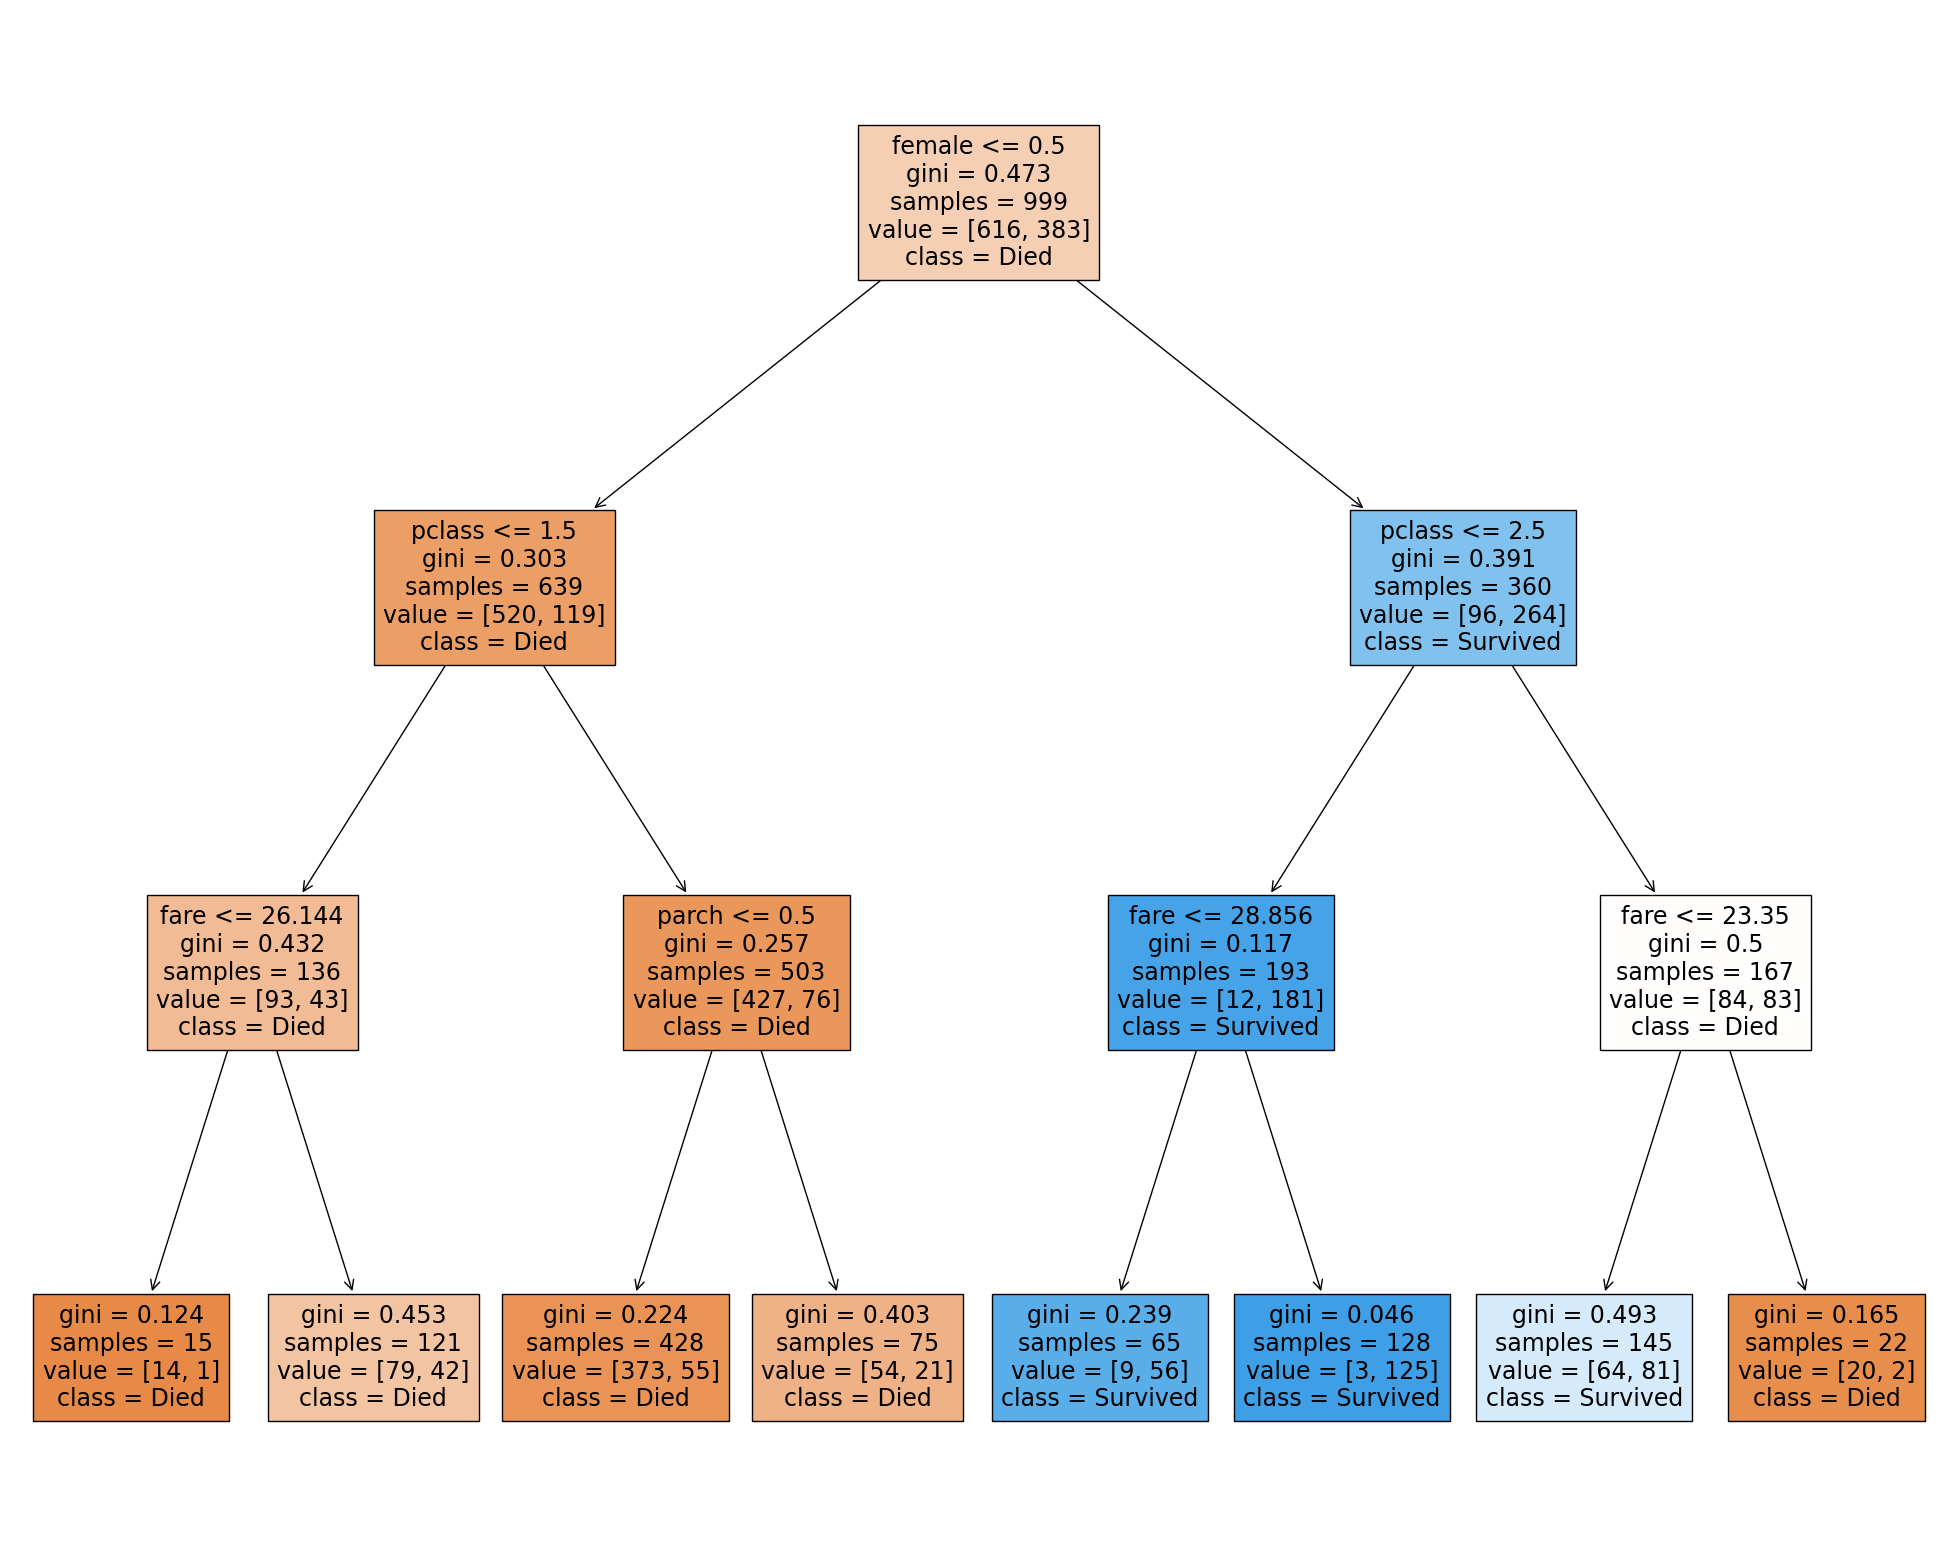

In [33]:
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree

clf = DecisionTreeClassifier(random_state=123, max_depth=3)
clf.fit(X, y)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=features,  
                   class_names=class_names,
                   filled=True)

# Spam data

In [35]:
# Load spam data
path_train = './hw5_code/dataset/spam/spam_data.mat'
data = scipy.io.loadmat(path_train)
X = data['training_data']
y = np.squeeze(data['training_labels'])
Z = data['test_data']
class_names = ["Ham", "Spam"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
scores = []
max_depth_range = range(1, 11)
for max_depth in max_depth_range:
    model = DecisionTree(max_depth = max_depth)
    scores.append(kfold(model, 5, X_train,y_train))
best_max_depth = max_depth_range[np.argmax(scores)]
print("Best max_depth value:", best_max_depth)
print('Best score',max(scores))

Best max_depth value: 10
Best score 0.8471563981042654


## Evaluate tree on spam

In [19]:
spam_tree_train,spam_tree_valid = evaluate(DecisionTree(max_depth = 10), X_train, X_test, y_train, y_test)
print("spam tree Train Accuracy:", spam_tree_train)
print("spam tree Validation Accuracy:", spam_tree_valid)

spam tree Train Accuracy: 0.8603219696969697
spam tree Validation Accuracy: 0.8257575757575758


## Evaluate random forest on spam

In [20]:
spam_rf_train,spam_rf_valid = evaluate(RandomForest(m = 20,n =50,params = {'max_depth':10}), X_train, X_test, y_train, y_test)
print("spam random forest Train Accuracy:", spam_rf_train)
print("spam random forest Validation Accuracy:", spam_rf_valid)

spam random forest Train Accuracy: 0.8330965909090909
spam random forest Validation Accuracy: 0.8106060606060606


## Submit spam

In [21]:
rf = DecisionTree(max_depth = 10)
rf.fit(X_train,y_train)
prediction = rf.predict(Z)
spam_submit = pd.DataFrame({'Id':range(1,len(prediction)+1),'Category':prediction})
spam_submit.to_csv('spam_submit_2.csv',index = False)

# 4.4 Performance Evaluation

In [22]:
# Create a dictionary with the values
results = {
    'Dataset': ['Titanic', 'Titanic', 'Spam', 'Spam'],
    'Classifier': ['Decision Tree', 'Random Forest', 'Decision Tree', 'Random Forest'],
    'Training Accuracy': [titanic_tree_train, titanic_rf_train, spam_tree_train, spam_rf_train],
    'Validation Accuracy': [titanic_tree_valid, titanic_rf_valid, spam_tree_valid, spam_rf_valid]
}

# Create a dataframe
df = pd.DataFrame(results)

df

,Dataset,Classifier,Training Accuracy,Validation Accuracy
0,Titanic,Decision Tree,0.872340,0.775000
1,Titanic,Random Forest,0.891114,0.810000
2,Spam,Decision Tree,0.860322,0.825758
3,Spam,Random Forest,0.833097,0.810606


# 4.5 Writeup Requirements for the Spam Dataset


In [23]:
# . Generate a random 80/20 training/validation split. Train decision trees with varying maximum depths(try going from depth = 1 to depth = 40)
max_depth_range = range(1, 41)
valid_accuracy = []
for max_depth in max_depth_range:
    model = DecisionTree(max_depth = max_depth)
    train,valid = evaluate(model, X_train, X_test, y_train, y_test)
    valid_accuracy.append(valid)


Text(0, 0.5, 'valid accuracy')

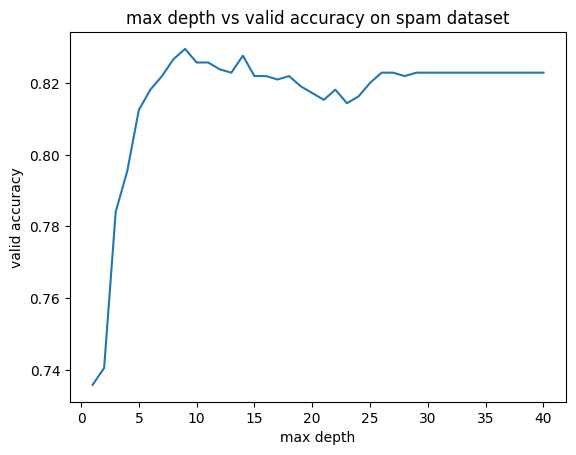

In [24]:
plt.plot(max_depth_range,valid_accuracy)
plt.title('max depth vs valid accuracy on spam dataset')
plt.xlabel('max depth')
plt.ylabel('valid accuracy')

In [39]:
features = [
    "pain", "private", "bank", "money", "drug", "spam", "prescription", "creative",
    "height", "featured", "differ", "width", "other", "energy", "business", "message",
    "volumes", "revision", "path", "meter", "memo", "planning", "pleased", "record", "out",
    "semicolon", "dollar", "sharp", "exclamation", "parenthesis", "square_bracket",
    "ampersand"
]

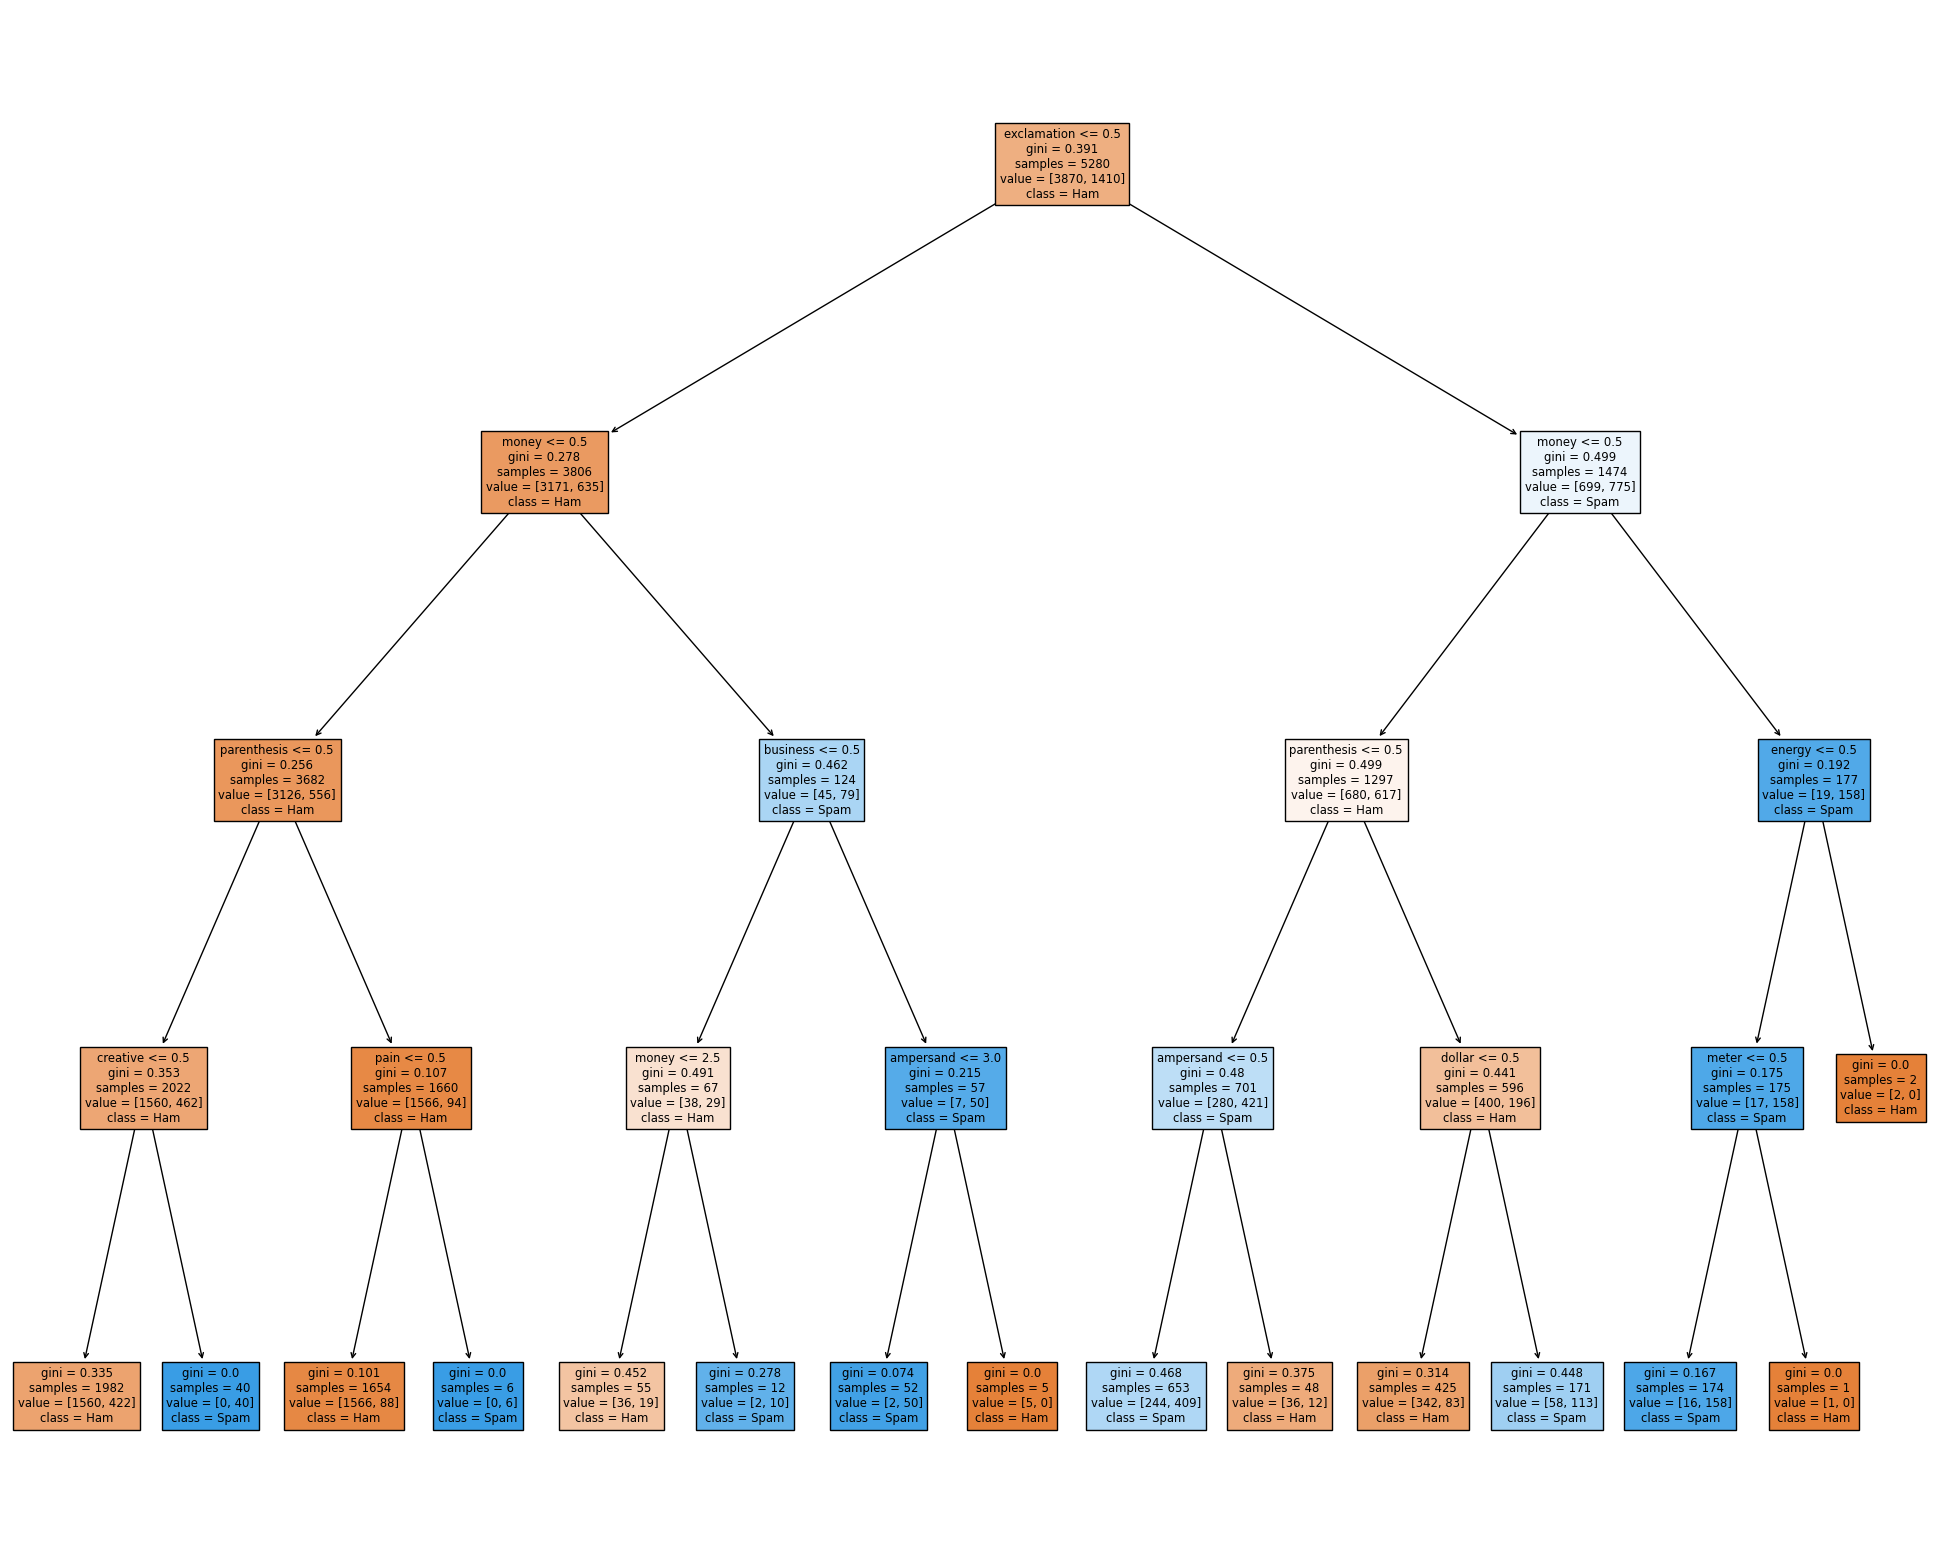

In [44]:
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree

clf = DecisionTreeClassifier(random_state=123, max_depth=4)
clf.fit(X, y)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=features,  
                   class_names=class_names,
                   filled=True)